<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S8/S8_Solution_py_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library'
sys.path.append(workingdir)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library


In [0]:
ls-ltr

total 24
drwx------ 2 root root 4096 Mar 14 15:38 data/
-rw------- 1 root root 2808 Mar 19 07:11 datatransformation.py
-rw------- 1 root root 9276 Mar 19 07:11 dnnmodel.py
-rw------- 1 root root  791 Mar 19 07:11 displayimages.py
-rw------- 1 root root 2515 Mar 19 07:11 showimages.py
-rw------- 1 root root 3140 Mar 19 07:11 train_test.py



Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
!pip install import-ipynb
import import_ipynb
#from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import os

#Below are the created modules
import dnnmodel 
import train_test
import datatransformation 
import showimages
import displayimages
from torch.optim.lr_scheduler import StepLR

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=ce06cd785b3781a97c221bd93bca8f03e259267eccbd6b42fb66dd42df376996
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
train_transforms,test_transforms= datatransformation.load()

In [0]:
classes,trainloader, testloader = datatransformation.dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


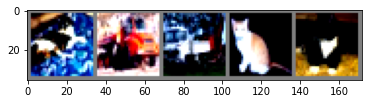

In [0]:
displayimages.show_random_image(trainloader,classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnnmodel.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
EPOCHS =20 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test.train(model, device, trainloader, optimizer, epoch,False)
    train_test.test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8161951303482056 Batch_id=390 Accuracy=53.88: 100%|██████████| 391/391 [03:14<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 6352/10000 (63.52%)

EPOCH: 1


Loss=0.7320898771286011 Batch_id=390 Accuracy=74.21: 100%|██████████| 391/391 [03:14<00:00,  2.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7493/10000 (74.93%)

EPOCH: 2


Loss=0.4058507978916168 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [03:13<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7382/10000 (73.82%)

EPOCH: 3


Loss=0.3794735372066498 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [03:13<00:00,  2.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7861/10000 (78.61%)

EPOCH: 4


Loss=0.27174898982048035 Batch_id=390 Accuracy=91.22: 100%|██████████| 391/391 [03:14<00:00,  2.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7772/10000 (77.72%)

EPOCH: 5


Loss=0.2287193238735199 Batch_id=390 Accuracy=93.71: 100%|██████████| 391/391 [03:13<00:00,  2.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7905/10000 (79.05%)

EPOCH: 6


Loss=0.13471226394176483 Batch_id=390 Accuracy=95.94: 100%|██████████| 391/391 [03:14<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7895/10000 (78.95%)

EPOCH: 7


Loss=0.03402348607778549 Batch_id=390 Accuracy=96.86: 100%|██████████| 391/391 [03:14<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 7591/10000 (75.91%)

EPOCH: 8


Loss=0.09872504323720932 Batch_id=390 Accuracy=97.69: 100%|██████████| 391/391 [03:13<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 7807/10000 (78.07%)

EPOCH: 9


Loss=0.07697974145412445 Batch_id=390 Accuracy=98.40: 100%|██████████| 391/391 [03:14<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7950/10000 (79.50%)

EPOCH: 10


Loss=0.0737275704741478 Batch_id=390 Accuracy=98.88: 100%|██████████| 391/391 [03:14<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8215/10000 (82.15%)

EPOCH: 11


Loss=0.03418834134936333 Batch_id=390 Accuracy=99.11: 100%|██████████| 391/391 [03:14<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8177/10000 (81.77%)

EPOCH: 12


Loss=0.004993015434592962 Batch_id=390 Accuracy=99.52: 100%|██████████| 391/391 [03:13<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8221/10000 (82.21%)

EPOCH: 13


Loss=0.0026519179809838533 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [03:13<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8361/10000 (83.61%)

EPOCH: 14


Loss=0.0024174153804779053 Batch_id=390 Accuracy=99.96: 100%|██████████| 391/391 [03:14<00:00,  2.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8442/10000 (84.42%)

EPOCH: 15


Loss=0.0006089329835958779 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [03:13<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8530/10000 (85.30%)

EPOCH: 16


Loss=0.0010848998790606856 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [03:14<00:00,  2.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8531/10000 (85.31%)

EPOCH: 17


Loss=0.0013064801460132003 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [03:15<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8537/10000 (85.37%)

EPOCH: 18


Loss=0.0004372835101094097 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [03:14<00:00,  2.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8546/10000 (85.46%)

EPOCH: 19


Loss=0.0010902166832238436 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [03:14<00:00,  2.53it/s]



Test set: Average loss: 0.0045, Accuracy: 8530/10000 (85.30%)



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    dog  frog   cat plane  deer
Predicted:    dog  frog   cat plane  deer


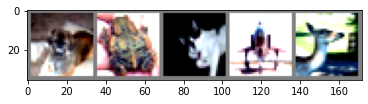

In [11]:
showimages.show_predicted_actual(model, device, testloader, classes)

Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [12]:
showimages.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 85 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [13]:
showimages.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 82 %
Accuracy of   car : 93 %
Accuracy of  bird : 80 %
Accuracy of   cat : 75 %
Accuracy of  deer : 79 %
Accuracy of   dog : 78 %
Accuracy of  frog : 80 %
Accuracy of horse : 89 %
Accuracy of  ship : 100 %
Accuracy of truck : 93 %
